In [59]:
!pip install matplotlib

In [1]:
import distrax
import haiku as hk
import optax
from jax import random
from jax import numpy as jnp

from surjectors.bijectors.masked_coupling import MaskedCoupling
from surjectors.conditioners.mlp import mlp_conditioner
from surjectors.distributions.transformed_distribution import \
    TransformedDistribution
from surjectors.surjectors.chain import Chain
from surjectors.util import make_alternating_binary_mask

import matplotlib.pyplot as plt

In [2]:
import blackjax

In [16]:
def _bijector_fn(params):
    means, log_scales = jnp.split(params, 2, -1)
    return distrax.ScalarAffine(means, jnp.exp(log_scales))


def _conditioner_fn(ndim_hidden_layers, n_hidden_layers, output_dim):
    return mlp_conditioner(
        [ndim_hidden_layers] * n_hidden_layers + [output_dim],
    )

def make_model(dim):
    def _flow(method, **kwargs):
        layers = []
        for i in range(2):
            mask = make_alternating_binary_mask(dim, i % 2 == 0)
            output_dim = dim * 2
            layer = MaskedCoupling(
                mask=mask,
                bijector=_bijector_fn,
                conditioner=_conditioner_fn(16, 2, output_dim=output_dim),
            )
            layers.append(layer)
        chain = Chain(layers)

        base_distribution = distrax.Independent(
            distrax.Normal(jnp.zeros(dim), jnp.ones(dim)),
            reinterpreted_batch_ndims=1,
        )
        td = TransformedDistribution(
            base_distribution,
            chain
        )
        return td(method, **kwargs)

    td = hk.transform(_flow)
    td = hk.without_apply_rng(td)
    return td

In [4]:
import numpy as np

import jax
import jax.numpy as jnp
import jax.scipy.stats as stats


loc, scale = 10, 20
observed = np.random.normal(loc, scale, size=1_000).reshape(-1, 2)
observed = jnp.asarray(observed)

def logdensity_fn(loc, observed=observed):
    logpdf = distrax.MultivariateNormalDiag(loc, jnp.ones_like(loc)).log_prob(observed)
    return jnp.sum(logpdf)


def logdensity(x):
    return logdensity_fn(**x)

In [5]:
inv_mass_matrix = jnp.array([0.1, 0.1])
step_size = 1e-3

nuts = blackjax.nuts(logdensity, step_size, inv_mass_matrix)

In [6]:
import multiprocessing


rng_key = jax.random.PRNGKey(0)
num_chains = 2

In [46]:
def inference_loop_multiple_chains(
    rng_key, kernel, initial_state, num_samples, num_chains
):

    @jax.jit
    def one_step(states, rng_key):
        keys = jax.random.split(rng_key, num_chains)
        states, _ = jax.vmap(kernel)(keys, states)
        return states, states

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)

    return states

In [56]:
initial_states

HMCState(position={'loc': Array([[9.597657, 9.705168],
       [9.494497, 9.643461]], dtype=float32)}, logdensity=Array([-198516.86, -198515.08], dtype=float32), logdensity_grad={'loc': Array([[-39.751076, -20.61447 ],
       [ 11.828781,  10.2388  ]], dtype=float32)})

In [62]:
jnp.ones((2,2)).shape

(2, 2)

In [69]:
def pr(state, s):
    return state / s
    
sss = jax.vmap(pr)(jnp.ones((2, 2, 2)), jnp.array([1, 2]))
sss

Array([[[1. , 1. ],
        [1. , 1. ]],

       [[0.5, 0.5],
        [0.5, 0.5]]], dtype=float32)

In [70]:
sss[0]

Array([[1., 1.],
       [1., 1.]], dtype=float32)

In [37]:
warmup = blackjax.window_adaptation(blackjax.nuts, logdensity)

In [41]:
initial_position = {"loc": jnp.ones((2, 2))} 
initial_states, kernel_params = jax.vmap(
    lambda seed, param: warmup.run(seed, param)[0]
)(random.split(random.PRNGKey(9), 2), initial_position)

In [42]:
kernel_params

{'inverse_mass_matrix': Array([[0.00190683, 0.00247511],
        [0.00218347, 0.00170437]], dtype=float32),
 'step_size': Array([0.7588432 , 0.83141214], dtype=float32, weak_type=True)}

In [43]:
kernel_params = {k: v[0] for k, v in kernel_params.items()}

In [44]:
_, kernel = blackjax.nuts(logdensity, **kernel_params)

In [72]:
states = inference_loop_multiple_chains(
    rng_key, kernel, initial_states, 2_000, 2
)
_ = states.position["loc"].block_until_ready()

In [73]:
states.position["loc"].shape

(2000, 2, 2)

In [74]:
states.position["loc"][:, 0, :].shape

(2000, 2)

In [75]:
samples = states.position["loc"]

In [76]:
samples.shape

(2000, 2, 2)

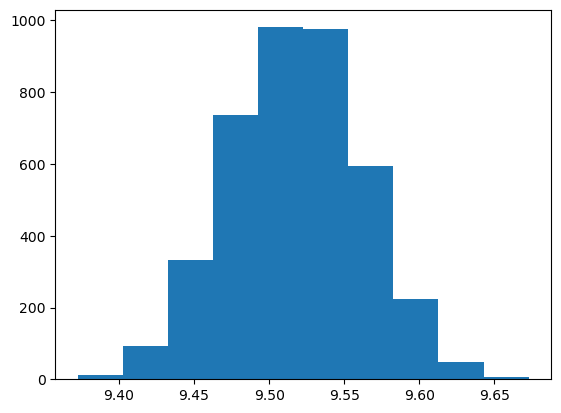

In [77]:
plt.hist(states.position["loc"][:, :, 0].flatten());

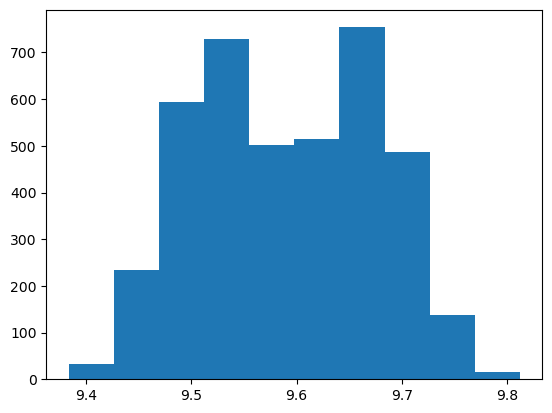

In [55]:
plt.hist(states.position["loc"][:, 1, :].flatten());

In [81]:
blackjax.diagnostics.effective_sample_size(states.position["loc"][:, :, 0])

Array(14408.24, dtype=float32)

In [80]:
blackjax.diagnostics.potential_scale_reduction(states.position["loc"][:, :, 0])

Array(0.9863291, dtype=float32)

In [71]:
s.T.shape

NameError: name 's' is not defined